In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data.csv')

# EDA of raw_data : 'data.csv'

Number of available stocks:202


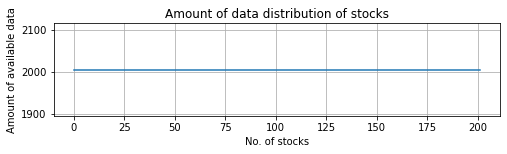

The number of missing value = 0


In [37]:
# Filtering out the stocks with inadequate data

tickcounts= data.ticker.value_counts()

availstocks = list(tickcounts[:202].index)# Since the dataset is already small. We could confidently throw away some stocks.
print('Number of available stocks:%d'%len(availstocks))
print('='*40)
plt.figure(figsize = (8,1.7))
plt.plot(tickcounts.values)
plt.ylabel('Amount of available data')
plt.xlabel('No. of stocks')
plt.title('Amount of data distribution of stocks')
plt.grid()
plt.show()

data = data[data['ticker'].isin(availstocks)]

# Check if there are missing values in the dataframe

print('The number of missing value = %d'%data.isnull().sum().sum())
print('='*40)


# Idea-generating for strategy


Since I only get price and vols, I should firstly generate some basic technical factors like moving average of prices and vols

- [ ] Let's consider the 'last' as the 'last tick'


In [46]:
_name = availstocks[0]
df = data[data['ticker']==_name]
df = df[['last','volume']]
df.index = np.arange(df.shape[0])

## Price factor

In [84]:
df['ma5'] = df['last'].rolling(window = 5).mean()
df['ma10'] = df['last'].rolling(window = 10).mean()
df['ma20'] = df['last'].rolling(window = 20).mean()

df['long_sig'] = (df['ma5']>df['ma10'])&(df['ma10']>df['ma20'])
df['short_sig'] = (df['ma5']<df['ma10'])&(df['ma10']<df['ma20'])
df.tail(4)

,last,volume,ma5,ma10,ma20,long_sig,short_sig
2001,552.0,1963700,555.8,549.1,533.6,True,False
2002,554.0,1450400,555.4,550.3,536.0,True,False
2003,565.0,1850200,557.6,553.9,538.0,True,False
2004,567.0,2451300,560.2,556.9,540.8,True,False


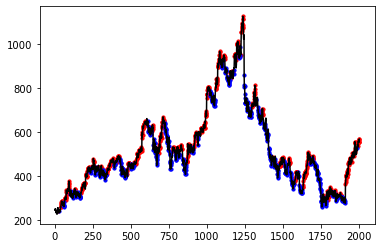

In [77]:
long_sig = list(df[df['long_sig']==1].index)
long_price = [df['last'].iloc[idx] for idx in long_sig]
short_sig = list(df[df['short_sig']==1].index)
short_price = [df['last'].iloc[idx] for idx in short_sig]

plt.scatter(long_sig, long_price,s = 10, color = 'r')
plt.scatter(short_sig, short_price,s = 10, color = 'blue')
plt.plot(df['last'].values,color = 'black')
plt.show()

In the graph above, we observe that the 
- [ ] red points appear when the stock rise.
- [ ] blue points appear when the stock drops.

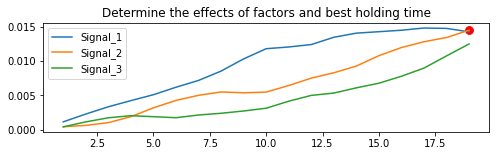

In [176]:
# Let's check if this factor is useful

# Dividing df into 3 part by long_sig, no_sig, short_sig

no_sig = list(df[(df['long_sig']==0) & (df['short_sig']==0)].index)
# Calculate the returns individually

    # indices = long_sig######
    # length = 15####
    
def calret(indices, length):
    newlist = [i for i in indices if (i<2005-length-1) ]
    new2list = [i+length for i in indices if (i<2005-length-1) ]
    df1 = df.loc[newlist]['last'].values
    df2 = df.loc[new2list]['last'].values
    ret = (df2-df1)/df1
    return ret

# Here we use the return mean as an indicator
hold_len = list(range(1,20))
hold_retlong = [calret(long_sig,t).mean() for t in hold_len]
hold_retno = [calret(no_sig,t).mean() for t in hold_len]
hold_retshort = [calret(short_sig,t).mean() for t in hold_len]

plt.figure(figsize= (8,2))
plt.title('Determine the effects of factors and best holding time')
plt.plot(hold_len, hold_retlong,label = 'Signal_1')
plt.plot(hold_len, hold_retno,label = 'Signal_2')
plt.plot(hold_len, hold_retshort,label = 'Signal_3')
plt.scatter(hold_len[-1], hold_retno[-1],s = 60, color= 'r')
plt.legend()
plt.show()

The reason I stopped searching is because the red dot above. I will explain it in further version : )

## volume factor

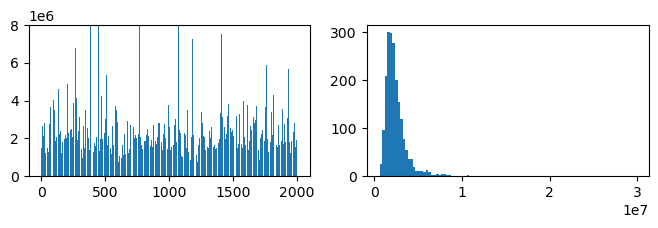

In [137]:
plt.figure(figsize =(8,2),dpi = 100)
plt.subplot(121)
plt.bar(range(len(df['volume'])), df['volume'])
plt.ylim(0,0.8e7)

plt.subplot(122)
plt.hist(df['volume'], bins = 100)

plt.show()

# df['volume'].describe()

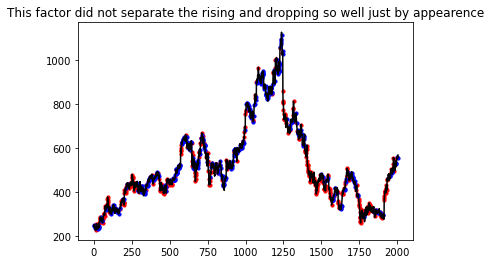

In [186]:
# volin_sig = df[]

from statsmodels.tsa.stattools import adfuller
adfuller(df['volume'])# Stationary
# Hence we could use the past dataset in future
import scipy.stats as stats
import statsmodels.api as sm


df['hi'] = (df['volume'] > df['volume'].describe()['75%'])
df['lo'] = (df['volume'] < df['volume'].describe()['25%'])

hi_sig = list(df[df['hi']==1].index)
lo_sig = list(df[df['lo']==1].index)

hi_price = [df['last'].iloc[idx] for idx in hi_sig]
lo_price = [df['last'].iloc[idx] for idx in lo_sig]

plt.scatter(hi_sig, hi_price,s = 10, color = 'r')
plt.scatter(lo_sig, lo_price,s = 10, color = 'blue')
plt.plot(df['last'].values,color = 'black')
plt.title('This factor did not separate the rising and dropping so well just by appearence')
plt.show()

I intended to directly show, not really clear.

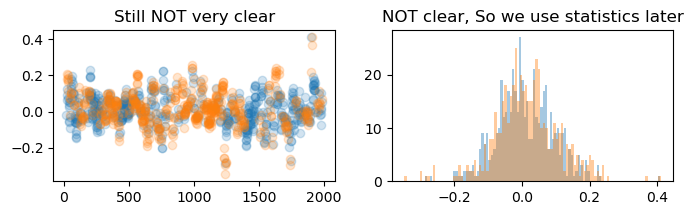

In [188]:
# 15days return 

tmpdf = df.copy()
tmpdf['15last'] = tmpdf['last'].shift(-15)
tmpdf['ret15'] = (tmpdf['15last']-tmpdf['last'])/tmpdf['last']

tmpdf = tmpdf.dropna()

hidf = tmpdf[tmpdf['hi']==1]
lodf = tmpdf[tmpdf['lo']==1]

plt.figure(figsize = (8,2),dpi = 100)
plt.subplot(121)
plt.title('Still NOT very clear')
plt.scatter(list(hidf.index),hidf['ret15'].values,alpha = 0.2)
plt.scatter(list(lodf.index),lodf['ret15'].values,alpha = 0.2)
plt.subplot(122)
plt.title('NOT clear, So we use statistics later')
plt.hist(hidf['ret15'].values,alpha = 0.4, bins = 100 )
plt.hist(lodf['ret15'].values,alpha = 0.4, bins = 100)
plt.show()

## Use t-stats to tell whether my volume factor could take effect

In [175]:
from scipy import stats 
print(stats.ttest_ind(hidf['ret15'].values,lodf['ret15'].values))
print('===========Hence, we cannot use these pair of factors, because p>0.05==========')

Ttest_indResult(statistic=-1.0943294732577258, pvalue=0.2740766809301102)
===========Hence, we cannot use these pair of factors, because p>0.05==========


In [184]:
print(stats.ttest_ind(hold_retlong, hold_retshort))
print(stats.ttest_ind(hold_retlong, hold_retno))
print('===========Hence,  Keep the factor, because p<0.1==========')

Ttest_indResult(statistic=3.8286724512489636, pvalue=0.0004954811015490555)
Ttest_indResult(statistic=2.0062038115433154, pvalue=0.0523925377251018)
===========Hence,  Keep the factor, because p<0.1==========


## The time left not too much, so I try a combination

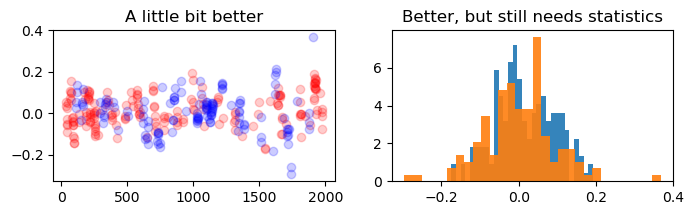

In [216]:
tmpdf = tmpdf.dropna()

longhi = list(tmpdf[(tmpdf['ma5']>tmpdf['ma10'])&(tmpdf['ma10']>tmpdf['ma20'])&(tmpdf['hi']==1)].index)
nolo = list(tmpdf[(tmpdf['ma5']<tmpdf['ma10'])&(tmpdf['ma10']<tmpdf['ma20'])&(tmpdf['lo']==1)].index)
longhiret = tmpdf[(tmpdf['ma5']>tmpdf['ma10'])&(tmpdf['ma10']>tmpdf['ma20'])&(tmpdf['hi']==1)]['ret15']
noloret = tmpdf[(tmpdf['ma5']<tmpdf['ma10'])&(tmpdf['ma10']<tmpdf['ma20'])&(tmpdf['lo']==1)]['ret15']

plt.figure(figsize = (8,2),dpi = 100)
plt.subplot(121)
plt.title('A little bit better')
plt.scatter(longhi,longhiret.values,alpha = 0.2, c = 'r')
plt.scatter(nolo,noloret.values,alpha = 0.2,c = 'b')
plt.subplot(122)
plt.title('Better, but still needs statistics')
plt.hist(longhiret.values,alpha = 0.9, bins = 30,density = True )
plt.hist(noloret.values,alpha = 0.9, bins = 30,density = True )
plt.show()

In [196]:
print(stats.ttest_ind(longhiret, noloret))
print('===========Hence,  Keep the factor, because p<0.1==========')
print('The combination works')

Ttest_indResult(statistic=-4.531104161898143, pvalue=8.386041356579832e-06)
===========Hence,  Keep the factor, because p<0.1==========
The combination works


# No.1 Stategy

| Item        |    Details   |   |   |   |   |   |
|----------------  |:-----------------------------------:|---|---|---|---|---|
| Targets        |    202 stocks in available stocks   |   |   |   |   |   |
| Buy points   | Signal_1,hi_1, position is not full |   |   |   |   |   |
| Holding length |        15 days                          |   |   |   |   |   |
| stop loss      | -10% for every deal                             |   |   |   |   |   |

In [305]:
class backtest1:
    def __init__(self,name,stoploss=0.1,holding_length=15):
        # Generating the price matrix
        
        tdf = data[data['ticker']==name].copy()
        tdf = tdf[['date','last','volume']]
        tdf.index = np.arange(tdf.shape[0])

        tdf['ma5'] = tdf['last'].rolling(window = 5).mean()
        tdf['ma10'] = tdf['last'].rolling(window = 10).mean()
        tdf['ma20'] = tdf['last'].rolling(window = 20).mean()
        tdf['long_sig'] = (tdf['ma5']>tdf['ma10'])&(tdf['ma10']>tdf['ma20'])
        tdf['short_sig'] = (tdf['ma5']<tdf['ma10'])&(tdf['ma10']<tdf['ma20'])
        
        self.hi = tdf['volume'].iloc[:1500].describe()['75%']
        self.lo = tdf['volume'].iloc[:1500].describe()['25%']
        tdf['hi'] = (tdf['volume']>self.hi)
        tdf['lo'] = (tdf['volume']<self.lo)
        
        tdf['15last'] = tdf['last'].shift(-holding_length)
        tdf['ret15'] = (tdf['15last']-tdf['last'])/tdf['last']
        self.tdf = tdf.iloc[1500:]
        self.stoploss = stoploss
        self.holding_length = holding_length
        
    def backtesting(self):
        self.pos = 0
        self.cap = 1
        self.earns = []
        self.net = [1]
        tdf = self.tdf
        nexttradeday = 0
        buyp = tdf['last'].iloc[0]
        for idx in range(tdf.shape[0]-self.holding_length-1):
            if idx == nexttradeday:
                m = (tdf['last'].iloc[idx]-buyp)/buyp
                self.net.append((1+m)*self.net[-1])
#                 print(self.net[-1],'asdf', buyp, tdf['last'].iloc[idx])
                self.pos = 0
            if (self.pos==1):
                m = (tdf['last'].iloc[idx]-buyp)/buyp
                self.net.append((1+m)*self.net[-1])
#                 print(self.net[-1],tdf['date'].iloc[idx],buyp,tdf['last'].iloc[idx], '======')
                continue
            if (not tdf['hi'].iloc[idx]) or (not tdf['long_sig'].iloc[idx]):
                self.net.append(self.net[-1])
                continue
            
            self.pos = 1
            buyp = tdf['last'].iloc[idx]
            nexttradeday = idx+self.holding_length
            self.earns.append(tdf['ret15'].iloc[idx])
            self.cap *= (1+tdf['ret15'].iloc[idx])
#             print(self.cap, tdf['date'].iloc[idx], tdf['last'].iloc[idx],tdf['15last'].iloc[idx],tdf['ret15'].iloc[idx])##
            
            self.net.append(self.net[-1])        
        self.cap = self.net[-1]
        return 
    

In [321]:
ts = []
for i in range(50):
    test = backtest1(availstocks[i],holding_length = 10)
    test.backtesting()
    t = test.net
    t= t[:480]
    ts.append(t)
    
ts = np.array(ts)
#     plt.plot(range(len(t)),t)


In [322]:
len(t)

480

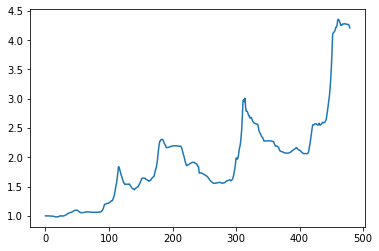

In [323]:
tsmean = ts.mean(axis = 0)
plt.plot(tsmean)


In [324]:
def MaxDrawdown(return_list):
    maxcum = np.zeros(len(return_list))
    b = return_list[0]
    for i in range(0,len((return_list))):
        if (return_list[i]>b):
            b = return_list[i]
        maxcum[i] = b
    i = np.argmax((maxcum-return_list)/maxcum) 
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])   
    
    return (return_list[j]-return_list[i])/return_list[j]

In [331]:
test.tdf.iloc[:480]

,date,last,volume,ma5,ma10,ma20,long_sig,short_sig,hi,lo,15last,ret15
1500,2019-02-19,4075.9183,2444400,4000.59030,3945.02654,3935.330855,True,False,False,False,4129.9904,0.013266
1501,2019-02-20,4099.2253,2712700,4027.06700,3958.54457,3941.297435,True,False,False,False,4116.0063,0.004094
1502,2019-02-21,4115.0740,2789200,4061.00190,3976.91044,3951.505875,True,False,False,False,4068.4601,-0.011328
1503,2019-02-22,4116.9386,1784500,4102.20858,3999.65802,3961.061725,True,False,False,True,4013.4557,-0.025136
1504,2019-02-25,4150.5006,2510500,4111.53136,4035.08458,3971.176940,True,False,False,False,4017.1848,-0.032120
...,...,...,...,...,...,...,...,...,...,...,...,...
1975,2021-02-04,4060.0000,2023600,3948.40000,3973.40000,3907.200000,False,False,False,True,4117.0000,0.014039
1976,2021-02-05,4060.0000,1963200,3986.80000,3969.40000,3938.600000,True,False,False,True,4199.0000,0.034236
1977,2021-02-08,4141.0000,2062900,4033.80000,3973.50000,3963.800000,True,False,False,True,4176.0000,0.008452
1978,2021-02-09,4143.0000,1600400,4080.80000,3992.70000,3988.450000,True,False,False,True,4314.0000,0.041274


In [343]:
print('MaxDraw:%f'%MaxDrawdown(tsmean))
print('Sharpe:',(tsmean[-1]**0.5-1.0)/np.std(tsmean))

MaxDraw:0.325306
Sharpe: 1.340815908280916


# Further research: Try to look into the fails of in the first factor. 

# Other supporting materials that are not considered as main materials

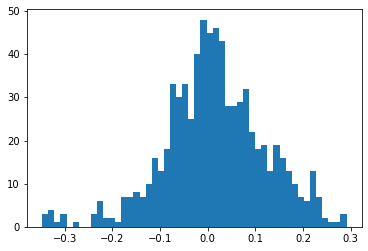

0.014159445419081963

In [111]:
plt.hist(ret,bins =50)
plt.show()
ret.mean()

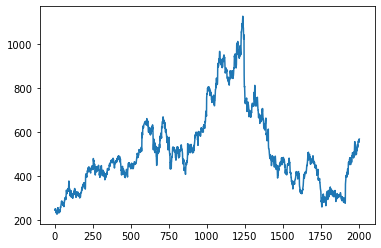

In [35]:
prices = data[data['ticker']==availstocks[0]]['last']
plt.plot(prices.values)